## Detecting Burned Areas using a CNN Model: The 2025 USA Wildfires ##



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Notebook Requirements ##

This notebook requires certain packages be installed.

• rasterio is used to read and write geospatial raster data like satellite images

• matplotlib helps visualise that data through plots and images

• scikit-learn provides tools for machine learning tasks such as classification or clustering based on raster features

They collectively help classify and analyse geospatial data

In [ ]:
! pip install rasterio matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 105.5 MB/s eta 0:00:00


In [ ]:

import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

from skimage.transform import resize
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
file_path = '/content/drive/MyDrive/AI4EO/'
# File path for Los Angeles 02/01/2025 and 01/02/2025 Data (pre and post)
a1_pre_path = file_path + 'Area 1/S2A_MSIL2A_20250102T183751_N0511_R027_T11SMT_20250102T221646.SAFE'
a1_post_path = file_path + 'Area 1/S2C_MSIL2A_20250201T183631_N0511_R027_T11SMT_20250201T210315.SAFE'

# File path for Dragoon Mountains, Arizona Area Data 08/05/2025 (post only)
a2_path = file_path + 'Area 2/S2B_MSIL2A_20250508T175909_N0511_R041_T12SWA_20250508T215203.SAFE'


## Loading, Preprocessing and Processing 2025 Los Angeles Fire Data ##

This model is going to be trained and tested using Sentinel-2 L2A data from the January 2025 Palisades and Eaton Wildfires in LA. This region was chosen due to the wildfires being recent, well documented and focused in specific regions.

The Green, Red, NIR and SWIR bands are the bands we need for burned area detection.

*   Green is Band 3
*   Red is Band 4
*   NIR is Band 8
*   SWIR is Band 11

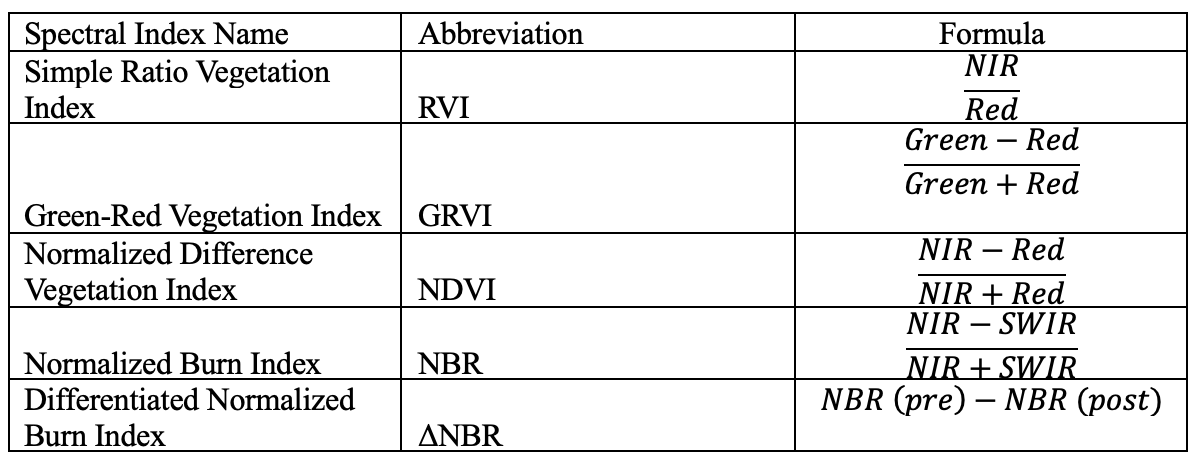


Normalised Burn Ratio (NBR):Used to identify and assess burned areas by analysing changes in near-infrared (NIR) and shortwave infrared (SWIR) reflectance. It is particularly sensitive to fire damage, as it captures moisture loss and vegetation destruction. The dNBR (difference NBR) is calculated by subtracting the post-fire NBR from the pre-fire NBR to evaluate burn severity.

Ratio Vegetation Index (RVI):An index used to monitor changes in vegetation by comparing red and NIR reflectance, helping to detect vegetation loss due to fire.

Green Ratio Vegetation Index (GRVI):Focuses on green reflectance and is effective for detecting changes in green vegetation cover following a fire event.

Normalised Difference Vegetation Index (NDVI):A widely used index to measure live green vegetation by comparing NIR and red reflectance. It is useful for assessing vegetation health and the extent of vegetation loss after fires.

These spectral indeces can all be used for analysing a burned area and based on the generated plots and models using the five indices I opted to focus on the NDVI, NBR and dNBR indices for their clearer differentiation between burned and unburned areas.

In [ ]:
# Identify the necessary Sentinel-2 bands
a1_bands = {
    'B03': 'B03_10m',  # Green
    'B04': 'B04_10m',  # Red
    'B08': 'B08_10m',  # NIR
    'B11': 'B11_20m'   # SWIR
}

# Define function to load one band
def load_band(safe_path, band_base_name):
    pattern = os.path.join(safe_path, 'GRANULE', '*', 'IMG_DATA', f'*{band_base_name}.jp2')
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"Band {band_base_name} not found in {safe_path}")
    return rasterio.open(files[0])

# Resample 20m bands to 10m resolution
def read_and_match_resolution(band_10m, band_20m):
    return band_20m.read(
        out_shape=(1, band_10m.height, band_10m.width),
        resampling=rasterio.enums.Resampling.bilinear
    )[0]

# Load all bands
a1_pre = {b: load_band(a1_pre_path, name) for b, name in a1_bands.items()}
a1_post = {b: load_band(a1_post_path, name) for b, name in a1_bands.items()}

# Read pre-fire bands
red_pre = a1_pre['B04'].read(1)
green_pre = a1_pre['B03'].read(1)
nir_pre = a1_pre['B08'].read(1)
swir_pre = read_and_match_resolution(a1_pre['B08'], a1_pre['B11'])

# Read post-fire bands
red_post = a1_post['B04'].read(1)
green_post = a1_post['B03'].read(1)
nir_post = a1_post['B08'].read(1)
swir_post = read_and_match_resolution(a1_post['B08'], a1_post['B11'])

# Index calculation function
def compute_index(numerator, denominator):
    return np.where((numerator + denominator) == 0, 0, (numerator - denominator) / (numerator + denominator))

# Compute indices
ndvi_pre = compute_index(nir_pre, red_pre)
ndvi_post = compute_index(nir_post, red_post)
nbr_pre = compute_index(nir_pre, swir_pre)
nbr_post = compute_index(nir_post, swir_post)
dnbr = nbr_pre - nbr_post
grvi = compute_index(green_post, red_post)
rvi = np.where(red_post == 0, 0, nir_post / red_post)


# Stack post-fire bands for NDWI
a1_band_stack = np.stack([green_post, red_post, nir_post, swir_post, ndvi_post, nbr_post], axis=-1)

# Burned area mask based on dNBR threshold
a1_burned_mask = (dnbr > 0.25).astype(np.uint8)

print("NDVI post-fire stats:", np.min(ndvi_post), np.max(ndvi_post))
print("dNBR stats:", np.min(dnbr), np.max(dnbr))
print("Burned pixels:", np.sum(a1_burned_mask))

# Save as .npy
np.save('/content/drive/MyDrive/AI4EO/burned_mask.npy', a1_burned_mask)

<ipython-input-6-e46fb8ecbd3f>:51: RuntimeWarning: divide by zero encountered in divide
  rvi = np.where(red_post == 0, 0, nir_post / red_post)


NDVI post-fire stats: 0.0 66.49536560247168
dNBR stats: -62.80492196248124 64.40091408631667
Burned pixels: 37538942


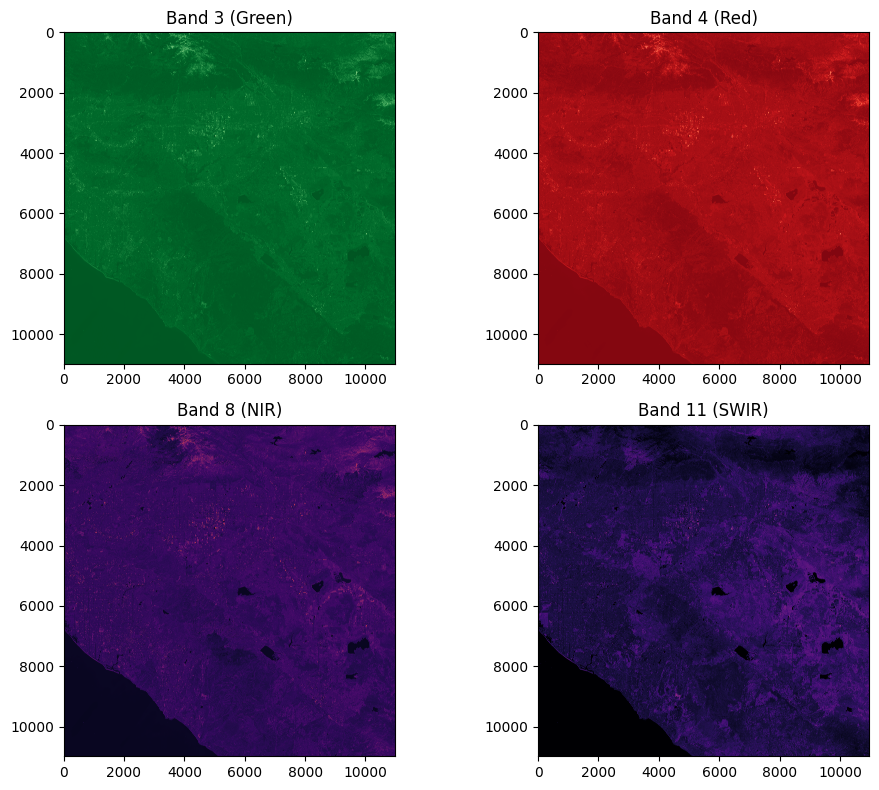

In [ ]:
# Visualise all 4 post-fire bands
# The fig variable will hold the figure object, and axes will be a 2x2 array of axes objects
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Assign individual axes from the 2x2 array
p1 = axes[0, 0]
p2 = axes[0, 1]
p3 = axes[1, 0]
p4 = axes[1, 1]

# Band 3: Green
p1.imshow(a1_band_stack[:, :, 0], cmap='Greens_r')
p1.set_title('Band 3 (Green)')

# Band 4: Red
p2.imshow(a1_band_stack[:, :, 1], cmap='Reds_r')
p2.set_title('Band 4 (Red)')

# Band 8: NIR
p3.imshow(a1_band_stack[:, :, 2], cmap='inferno')
p3.set_title('Band 8 (NIR)')

# Band 11: SWIR
p4.imshow(a1_band_stack[:, :, 3], cmap='magma')
p4.set_title('Band 11 (SWIR)')

plt.tight_layout()
plt.show()

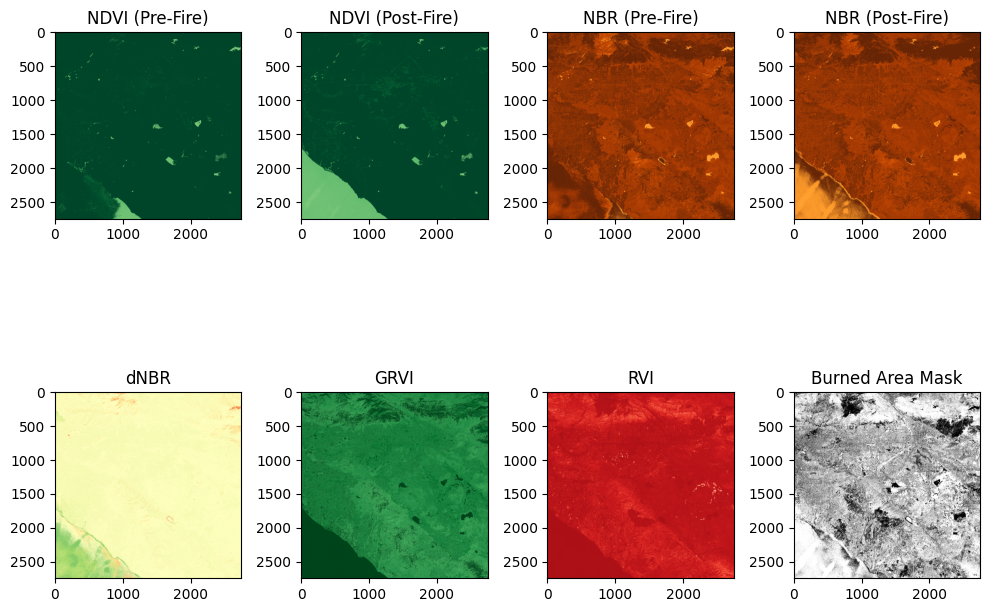

<Figure size 640x480 with 0 Axes>

In [ ]:
 # Plotting The key indices
fig, axes = plt.subplots(2, 4, figsize=(10, 8))
p1 = axes[0,0]
p2 = axes[0,1]
p3 = axes[0,2]
p4 = axes[0,3]
p5 = axes[1,0]
p6 = axes[1,1]
p7 = axes[1,2]
p8 = axes[1,3]

p1.imshow(ndvi_pre[::4, ::4], cmap='YlGn_r')
p1.set_title("NDVI (Pre-Fire)")

p2.imshow(ndvi_post[::4, ::4], cmap='YlGn_r')
p2.set_title("NDVI (Post-Fire)")

p3.imshow(nbr_pre[::4, ::4], cmap='YlOrBr_r')
p3.set_title("NBR (Pre-Fire)")

p4.imshow(nbr_post[::4, ::4], cmap='YlOrBr_r')
p4.set_title("NBR (Post-Fire)")

p5.imshow(dnbr[::4, ::4], cmap='RdYlGn_r')
p5.set_title("dNBR")

p6.imshow(grvi[::4, ::4], cmap='Greens_r')
p6.set_title("GRVI")

p7.imshow(rvi[::4, ::4], cmap='Reds_r')
p7.set_title("RVI")

p8.imshow(a1_burned_mask[::4, ::4], cmap='binary')
p8.set_title("Burned Area Mask")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

## Generating a Mask ##
Here the post-fire bands and spectral indices are stacked into a 6-channel input array. The burned area mask is generated using a dNBR threshold of 0.25. This is higher than the commonly used empirical cutoff for fire detection in order to improve accuracy and precision.

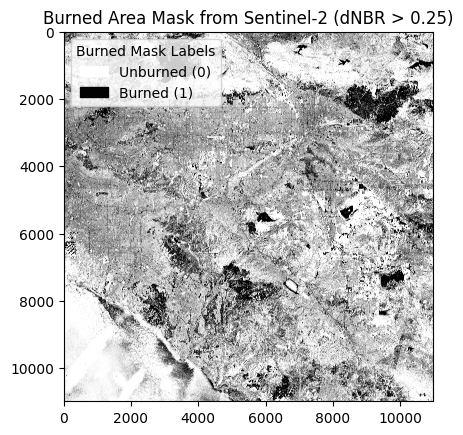

In [ ]:
from matplotlib.patches import Rectangle

# Create custom legend for burned vs unburned
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.0)),   # Unburned (0)
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Burned (1)
]
labels = ['Unburned (0)', 'Burned (1)']
plt.legend(patches, labels, loc='upper left', title='Burned Mask Labels')

# Plotting the burned area mask
plt.imshow(a1_burned_mask, cmap='binary')
plt.title('Burned Area Mask from Sentinel-2 (dNBR > 0.25)')
plt.savefig('/content/drive/MyDrive/AI4EO/burned_area_mask_legend.png', bbox_inches='tight')
plt.show()

In [ ]:
# Each pixel is 10m x 10m = 100 m² = 0.0001 km²
burned_area_km2 = np.sum(a1_burned_mask) * 0.0001
print(f"Estimated burned area: {burned_area_km2:.2f} km²")

Estimated burned area: 3753.89 km²


## Model Generation ##
This is the section that focuses on taking the processed data and using it to generate a CNN model.16x16 image patches are extracted from the post-fire data and assign labels (burned/unburned) based on the center pixel of the dNBR mask. These labeled patches are used to train the CNN model. A small CNN is defined with two convolutional layers followed by dense layers. It’s trained using categorical cross-entropy on 80/20 train-validation splits. I chose to use 10 epochs to balance RAM usage, model quality and environmental impact.

The trained model is saved as burned_area_cnn.h5 for later inference on unseen post-fire data from a different region.

In [ ]:
a1_band_stack = (a1_band_stack - a1_band_stack.min()) / (a1_band_stack.max() - a1_band_stack.min())

# Extract patches for training
patch_size = 16
stride = 16
X, y = [], []
h, w, _ = a1_band_stack.shape

for i in range(0, h - patch_size + 1, stride):
    for j in range(0, w - patch_size + 1, stride):
        patch = a1_band_stack[i:i+patch_size, j:j+patch_size, :]
        label = a1_burned_mask[i+patch_size//2, j+patch_size//2]
        X.append(patch)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(patch_size, patch_size, 6)),
    MaxPooling2D(2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fire_fitting = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)
model.save('/content/drive/MyDrive/AI4EO/burned_area_cnn.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7156 - loss: 0.5545 - val_accuracy: 0.7567 - val_loss: 0.4937
Epoch 2/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.7570 - loss: 0.4927 - val_accuracy: 0.7654 - val_loss: 0.4798
Epoch 3/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.7666 - loss: 0.4786 - val_accuracy: 0.7674 - val_loss: 0.4759
Epoch 4/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7721 - loss: 0.4685 - val_accuracy: 0.7757 - val_loss: 0.4663
Epoch 5/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.7760 - loss: 0.4611 - val_accuracy: 0.7751 - val_loss: 0.4655
Epoch 6/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7800 - loss: 0.4576 - val_accuracy: 0.7755 - val_loss: 0.4623
Epoch 7/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.7821 - loss: 0.4521 - val_accuracy: 0.7834 - val_loss: 0.4518
Epoch 8/20
11765/11765 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 

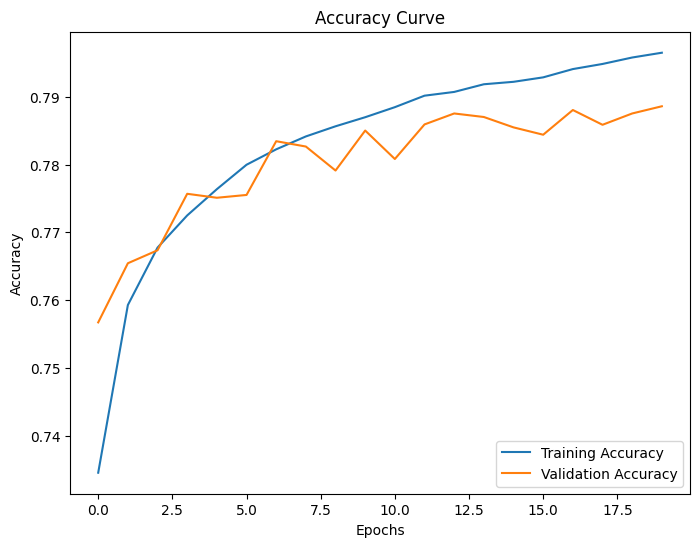

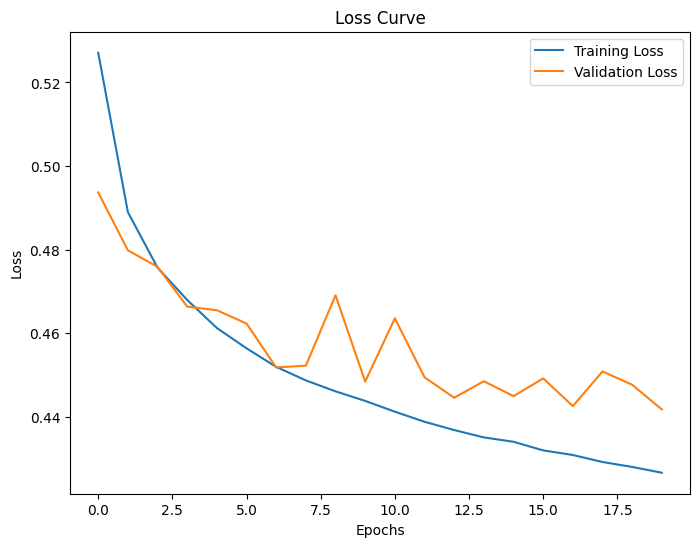

In [ ]:
# Plot the loss and accuracy curves
def plot_training_curves(fire_fitting):
    # Extract values from the fire_fitting object
    acc = fire_fitting.fire_fitting['accuracy']
    val_acc = fire_fitting.fire_fitting['val_accuracy']
    loss = fire_fitting.fire_fitting['loss']
    val_loss = fire_fitting.fire_fitting['val_loss']
    epochs_range = range(len(acc))

    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Call the function to plot the curves
plot_training_curves(fire_fitting)

In [ ]:
model_path = file_path + 'burned_area_cnn.h5'

## Burned Area Prediction with the CNN model ##

The saved CNN model is applied to a new region (in this case Dragoon Mountains, Arizona, also in the United States but from a wildfire later on in the year) by extracting patches in the same way and predicting whether each patch is burned. The predictions are aggregated and resized to match the image resolution.


In [ ]:
# Load Sentinel-2 Bands
a2_bands = {
    'B03': 'B03_10m',  # Green
    'B04': 'B04_10m',  # Red
    'B08': 'B08_10m',  # NIR
    'B11': 'B11_20m'   # SWIR
}

def load_band(safe_path, band_base_name):
    pattern = f"{safe_path}/GRANULE/*/IMG_DATA/{band_base_name}.jp2"
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"Band {band_base_name} not found in {safe_path}")
    return rasterio.open(files[0])

def read_and_match_resolution(band_10m, band_20m):
    return band_20m.read(
        out_shape=(1, band_10m.height, band_10m.width),
        resampling=rasterio.enums.Resampling.bilinear
    )[0]

In [ ]:
# Load and read bands
test = {b: load_band(a2_path, name) for b, name in a2_bands.items()}
red = test['B04'].read(1)
green = test['B03'].read(1)
nir = test['B08'].read(1)
swir = read_and_match_resolution(test['B08'], test['B11'])

# Compute Indices
def compute_index(numerator, denominator):
    return np.where((numerator + denominator) == 0, 0, (numerator - denominator) / (numerator + denominator))

ndvi = compute_index(nir, red)
nbr = compute_index(nir, swir)

# Stack inputs
a2_band_stack = np.stack([red, green, nir, swir, ndvi, nbr], axis=-1)
stack = (a2_band_stack - a2_band_stack.min()) / (a2_band_stack.max() - a2_band_stack.min())  # Normalise to 0-1

In [ ]:
# Extract patches
patch_size = 16
stride = 16
h, w, _ = a2_band_stack.shape
patches = []

for i in range(0, h - patch_size + 1, stride):
    for j in range(0, w - patch_size + 1, stride):
        patch = a2_band_stack[i:i+patch_size, j:j+patch_size, :]
        if patch.shape == (patch_size, patch_size, 6):
            patches.append(patch)

x_test_all = np.array(patches)
print("Extracted patches:", x_test_all.shape)

Extracted patches: (470596, 16, 16, 6)


In [ ]:
# Load Model and Predict
cnn_model = load_model(model_path)
batch_size = 512
n_patches = x_test_all.shape[0]
output_h = (h - patch_size) // stride + 1
output_w = (w - patch_size) // stride + 1
output = np.zeros((output_h, output_w), dtype=np.uint8)

for i in range(0, n_patches, batch_size):
    batch = x_test_all[i:i + batch_size]
    preds = cnn_model.predict(batch, verbose=0)
    labels = np.argmax(preds, axis=1)

    for b, label in enumerate(labels):
        idx = i + b
        row = idx // output_w
        col = idx % output_w
        if row < output_h and col < output_w:
            output[row, col] = label

# Resize output back to image resolution
resized_output = resize(output, (h, w), order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)


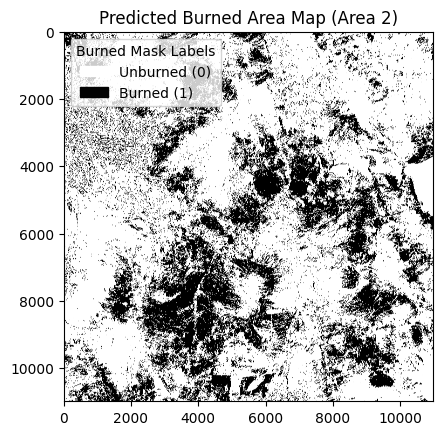

In [ ]:
# Create custom legend for burned vs unburned
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.0)),   # Unburned (0)
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Burned (1)
]
labels = ['Unburned (0)', 'Burned (1)']
plt.legend(patches, labels, loc='upper left', title='Burned Mask Labels')

# Save & Visualise ===
# Plotting the burned area mask
np.save(file_path + 'cnn_predicted_map.npy', resized_output)
plt.imshow(resized_output, cmap='binary')
plt.title("Predicted Burned Area Map (Area 2)")
plt.savefig(file_path + 'a2_predicted_burn_area_mask.png', bbox_inches='tight')
plt.show()

In [ ]:
# Calculate the number of burned pixels
burned_pixels_predicted = np.sum(resized_output == 1)

# Calculate the burned area in square kilometers
predicted_burned_area_km2 = burned_pixels_predicted * 0.0001

print(f"Estimated burned area from predicted map: {predicted_burned_area_km2:.2f} km²")

Estimated burned area from predicted map: 3490.21 km²


## Conclusion and Model Performance Metrics ##

We calculate precision, recall, F1-score, and overall accuracy for the model on the validation set, Los Angeles. This gives a quick insight into how well the CNN is performing. Accuracy of the model is about 80% while precision is closer to 50%. The model seems to excel at identifying un-burned regions but struggles with burned areas. This helps identify regions that may be safe to relocate to and the identification of burned regions can be improved by introducing more data into the model in an environment where more RAM is available as that is the key disadvantage of using Google Colab. Tools like this model can support disaster response and environmental monitoring with minimal manual intervention, contributing to aid efforts.

In [ ]:
mask_path = file_path + 'burned_mask.npy'
prediction_path = file_path + 'cnn_predicted_map.npy'
ground_truth = np.load(mask_path)
prediction = np.load(prediction_path)

In [ ]:
# Resize prediction to match ground truth if necessary
if prediction.shape != ground_truth.shape:
    from skimage.transform import resize
    prediction = resize(prediction, ground_truth.shape, order=0, preserve_range=True).astype(np.uint8)

# Flatten for metrics
y_true = ground_truth.flatten()
y_pred = prediction.flatten()\
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Unburned", "Burned"]))


Classification Report:
              precision    recall  f1-score   support

    Unburned       0.69      0.71      0.70  83021458
      Burned       0.32      0.30      0.31  37538942

    accuracy                           0.58 120560400
   macro avg       0.51      0.50      0.50 120560400
weighted avg       0.58      0.58      0.58 120560400



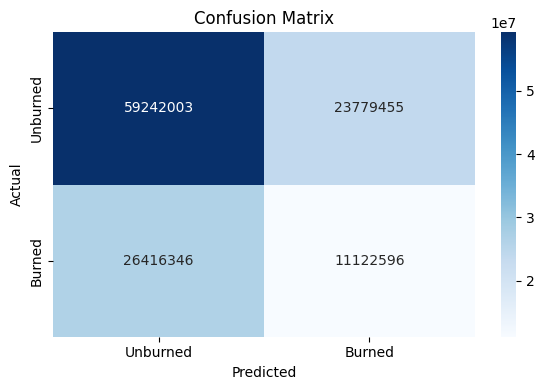

In [ ]:
# Confusion Matrix ===
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Unburned", "Burned"], yticklabels=["Unburned", "Burned"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()